In [1]:
import sys
sys.path.append('../code/') 
import mocap_functions
import numpy as np
import pandas as pd
import neo
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy import signal
from scipy.interpolate import interp1d
import spike_train_functions
import elephant
import quantities as pq
# import h5py
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch
import torch
from torch import nn
import torch.nn.functional as F
from joblib import Parallel, delayed
import multiprocessing
import Neural_Decoding
import pickle
from hnn_core.utils import smooth_waveform
from functools import partial
from copy import deepcopy
num_cores = multiprocessing.cpu_count()
scaler = StandardScaler()

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0")
# device = torch.device('cpu')

torch.backends.cudnn.benchmark = True

In [2]:
kinematic_df, neural_df, metadata = mocap_functions.load_mocap_df('../data/SPK20220308/task_data/')
num_trials = metadata['num_trials']

#Generate cv_dict for regular train/test/validate split (no rolling window)
cv_split = ShuffleSplit(n_splits=5, test_size=.25, random_state=0)
val_split = ShuffleSplit(n_splits=1, test_size=.25, random_state=0)
cv_dict = {}
for fold, (train_val_idx, test_idx) in enumerate(cv_split.split(np.arange(num_trials))):
    for t_idx, v_idx in val_split.split(train_val_idx): #No looping, just used to split train/validation sets
        cv_dict[fold] = {'train_idx':train_val_idx[t_idx], 
                         'test_idx':test_idx, 
                         'validation_idx':train_val_idx[v_idx]}

In [3]:
# Filter dataframes to separate object, body, and eye markers
forelimb_markers = ['carpal', 'radiusProx', 'radiusDistal', 'ulnarProx', 'ulnarDistal']
eye_markers = ['eye', 'cornea']
finger_markers = ['ring', 'pinky', 'thumb', 'index', 'middle']
forelimb_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in forelimb_markers])
finger_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in finger_markers])
eye_mask = np.logical_or.reduce([kinematic_df['name'].str.contains(pat=pat) for pat in eye_markers])


forelimb_df = kinematic_df[forelimb_mask]
finger_df = kinematic_df[finger_mask]
eyes_df = kinematic_df[eye_mask]


In [30]:
def make_generators(pred_df, neural_df, neural_offset, cv_dict):
    sampling_rate = 100
    kernel_offset = int(metadata['kernel_halfwidth'] * sampling_rate)  #Convolution kernel centered at zero, add to neural offset
    offset = neural_offset + kernel_offset
    window_size = 10
    data_step_size = 1 

    # Set up PyTorch Dataloaders
    fold=3
    kinematic_type = 'posData'
    # Parameters
    batch_size = 10000
    train_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    train_eval_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}
    validation_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': num_cores, 'pin_memory':False}
    test_params = {'batch_size': batch_size, 'shuffle': False, 'num_workers': num_cores, 'pin_memory':False}

    predict_kinematics=True
    # Generators
    training_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'train_idx', pred_df, neural_df, offset, window_size, 
                                                data_step_size, device, 'posData', True, predict_kinematics)
    training_generator = torch.utils.data.DataLoader(training_set, **train_params)
    training_eval_generator = torch.utils.data.DataLoader(training_set, **train_eval_params)
    X_train_data = training_set[:][0][:,-1,:].detach().cpu().numpy()
    y_train_data = training_set[:][1][:,-1,:].detach().cpu().numpy()

    validation_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'validation_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    validation_generator = torch.utils.data.DataLoader(validation_set, **validation_params)

    testing_set = mocap_functions.SEE_Dataset(cv_dict, fold, 'test_idx', pred_df, neural_df, offset, window_size, 
                                                    data_step_size, device, 'posData', True, predict_kinematics)
    testing_generator = torch.utils.data.DataLoader(testing_set, **test_params)
    X_test_data = testing_set[:][0][:,-1,:].detach().cpu().numpy()
    y_test_data = testing_set[:][1][:,-1,:].detach().cpu().numpy()

    data_arrays = (X_train_data, y_train_data, X_test_data, y_test_data)
    generators = (training_generator, training_eval_generator, validation_generator)

    return data_arrays, generators 

def run_wiener(pred_df, neural_df, neural_offset, cv_dict):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset, cv_dict)

    # Unpack tuple into variables
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays
    training_generator, training_eval_generator, validation_generator = generators

    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

    return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_wiener_eyes(pred_df, neural_df, eyes_df, neural_offset, cv_dict):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset, cv_dict)

    # Unpack tuple into variables
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays
    #training_generator, training_eval_generator, validation_generator = generators


    data_arrays, generators = make_generators(eyes_df, neural_df, neural_offset, cv_dict)
    # Unpack tuple into variables
    _, eye_train_data, _, eye_test_data = data_arrays
    #training_generator, training_eval_generator, validation_generator = generators

    X_train_data = np.hstack([X_train_data, eye_train_data])
    X_test_data = np.hstack([X_test_data, eye_test_data])

    #Fit and run wiener filter
    model_wr = Neural_Decoding.decoders.WienerFilterDecoder() 
    model_wr.fit(X_train_data,y_train_data)

    wr_train_pred = model_wr.predict(X_train_data)
    wr_test_pred = model_wr.predict(X_test_data)

    #Compute decoding
    wr_train_corr = mocap_functions.matrix_corr(wr_train_pred,y_train_data)
    wr_test_corr = mocap_functions.matrix_corr(wr_test_pred,y_test_data)

    return wr_train_pred, wr_test_pred, wr_train_corr, wr_test_corr

def run_ann(pred_df, neural_df, neural_offset, cv_dict):
    data_arrays, generators = make_generators(pred_df, neural_df, neural_offset)

    # Unpack tuple into variables
    X_train_data, y_train_data, X_test_data, y_test_data = data_arrays
    training_generator, training_eval_generator, validation_generator = generators

    #Define hyperparameters
    lr = 1e-3
    weight_decay = 1e-5
    layer_size=[100]
    max_epochs=1000
    input_size = X_train_data.shape[1] 
    output_size = y_train_data.shape[1] 

    model_ann = mocap_functions.model_ann(input_size,output_size,layer_size).to(device)
    # Define Loss, Optimizerints h
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model_ann.parameters(), lr=lr, weight_decay=weight_decay)

    #Train model
    loss_dict = mocap_functions.train_validate_model(model_ann, optimizer, criterion, max_epochs, training_generator, validation_generator, device, 10, 5)

    #Evaluate trained model
    ann_train_pred = mocap_functions.evaluate_model(model_ann, training_eval_generator, device)
    ann_test_pred = mocap_functions.evaluate_model(model_ann, validation_generator, device)
    
    #Compute decoding
    ann_train_corr = mocap_functions.matrix_corr(ann_train_pred,y_train_data)
    ann_test_corr = mocap_functions.matrix_corr(ann_test_pred,y_test_data)

    return ann_train_pred, ann_test_pred, ann_train_corr, ann_test_corr
    

In [31]:
#carpal_df = kinematic_df[kinematic_df['name'].str.contains(pat='carpal')]
carpal_df = kinematic_df[kinematic_df['name'].str.contains(pat='carpal')]
eye_df = kinematic_df[kinematic_df['name'].str.contains(pat='eye')]

# Smooth data
carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=400, sfreq=100))
eye_df['posData'] = eye_df['posData'].map(partial(smooth_waveform, window_len=400, sfreq=100))

offset = 20

carpal_train_pred, carpal_test_pred, carpal_train_corr, carpal_test_corr = run_wiener_eyes(carpal_df, neural_df, eye_df, offset, cv_dict)
#carpal_train_pred, carpal_test_pred, carpal_train_corr, carpal_test_corr = run_ann(carpal_df, neural_df, offset)

# Unpack tuple into variables
data_arrays, _ = make_generators(carpal_df, neural_df, offset, cv_dict)
X_train_data, y_train_data, X_test_data, y_test_data = data_arrays

# ANN training code
#eyes_train_pred, eyes_test_pred, eyes_train_corr, eyes_test_corr = run_ann(eyes_df, neural_df, eyes_offset)
#forelimb_train_pred, forelimb_test_pred, forelimb_train_corr, forelimb_test_corr = run_ann(forelimb_df, neural_df, forelimb_offset)
#finger_train_pred, finger_test_pred, finger_train_corr, finger_test_corr = run_ann(finger_df, neural_df, finger_offset)
#eyes_train_pred, eyes_test_pred, eyes_train_corr, eyes_test_corr = run_ann(eyes_df, neural_df, eyes_offset)

/tmp/ipykernel_21501/4058235035.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  carpal_df['posData'] = carpal_df['posData'].map(partial(smooth_waveform, window_len=400, sfreq=100))
/tmp/ipykernel_21501/4058235035.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  eye_df['posData'] = eye_df['posData'].map(partial(smooth_waveform, window_len=400, sfreq=100))


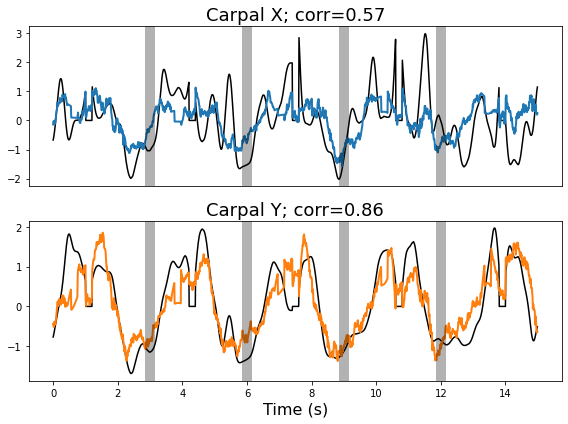

In [35]:
plt.figure(figsize=(8, 6))
tstart = 1800
bounds = np.arange(tstart, tstart + 1500)
x_vals = np.arange(len(bounds))/100

marker_names = ['Carpal X', 'Carpal Y', 'Carpal Z']
for col_idx in range(2):
    plt.subplot(2, 1, col_idx+1)
    plt.plot(x_vals, y_test_data[bounds, col_idx], color='k')
    plt.plot(x_vals, carpal_test_pred[bounds, col_idx], color=f'C{col_idx + 0}', linewidth=2)
    plt.title(f'{marker_names[col_idx]}; corr={np.round(carpal_test_corr[col_idx], 2)}', fontsize=18)
    
    if col_idx == 1:
        plt.xlabel('Time (s)', fontsize=16)
    else:
        plt.xticks([])
    
    plt.ylim(plt.ylim())
    plt.xlim(plt.xlim())
    
    plt.vlines(x=[3, 6, 9, 12],ymin=-10, ymax=10, color='k', linewidth=10, linestyle='-', alpha=0.3)
plt.tight_layout()
plt.savefig(f'movement_decoding_final.svg')

In [15]:
kinematic_df.uniqu

,name,posData,trial,layout
0,thumbProx_x,"[154.17128697416797, 102.06302090450197, 49.95...",0,1
1,thumbProx_y,"[-288.037356179243, -195.43547470688122, -102....",0,1
2,thumbProx_z,"[8650.34304328337, 8671.91821453189, 8693.4933...",0,1
3,thumbDistal_x,"[-38.36908269475009, -39.425876895543986, -40....",0,1
4,thumbDistal_y,"[-52.830470566075974, -52.14158377604938, -51....",0,1
...,...,...,...,...
22231,lefteye_pupilbottom_y,"[503.232, 503.4557218045113, 503.6794436090226...",217,2
22232,lefteye_pupiloutside_x,"[1014.87, 1014.7475939849624, 1014.62518796992...",217,2
22233,lefteye_pupiloutside_y,"[485.046, 485.3697969924812, 485.6935939849624...",217,2
22234,single_cornealRefR_x,"[965.175, 964.9024812030075, 964.629962406015,...",217,2
